## GPT-2 预训练模型及文本生成

#### 介绍

在上一节中，我们学习了 BERT ，它能够在多种自然语言处理相关任务上有很好的表现，在本次实验我们将学习另一个有着优秀表现的预训练模型：GPT-2 模型，以及使用它进行文本生成任务实践。

#### 知识点

- GPT-2 的核心思想
- GPT-2 模型结构详解
- GPT-2 进行文本生成

---

OpenAI 在论文 [Improving Language Understanding by Generative Pre-Training](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) 中提出了 GPT 模型。GPT 模型是由单向 Transformer 的解码器构建的模型，OpenAI 团队在一个非常大的书籍数据集 [the Toronto Book Corpus](https://yknzhu.wixsite.com/mbweb) 上对其进行了无监督预训练。

而后，OpenAI 团队又提出了 [GPT-2 模型](https://openai.com/blog/better-language-models/)，GPT-2 模型是 GPT 模型的后继，使用了更大的训练集训练，有更多的参数，是 GPT 模型的扩大版。GPT-2 的训练集为数量有 8 百万的网页，由研究人员从网络上爬取得到，大小共有 40 GB 的文本数据，训练任务为给出上文，使模型预测下一个单词。

由于 GPT 与 GPT-2 模型的差别就在于 GPT-2 使用了更多的训练数据，增加了模型参数，在具体结构上并无较大差异。所以，下面我们主要介绍实际表现更优异的 GPT-2 模型。

### GPT-2 核心思想

根据研究发现，语言有灵活的表达能力，即能够将任务、输入、输出表示成一个字符串，并且模型可以用这种形式的字符串进行训练，学习相应任务。例如，在翻译任务中，一个训练样本可以被写成

<pre>
(translate to french, english text, french text)
</pre>

同样地，在阅读理解任务中，一个训练样本可以被写成

<pre>
(answer the question, document, question, answer)
</pre>

并且，人们可以用以上格式的多种任务的训练样本同时训练一个模型，使得该模型获得同时执行多种任务的能力。

于是 OpenAI 研究人员推测，一个具有足够能力的语言模型将学习到推理和执行训练样本中所展示出的任务，以便更好地预测它们。如果一个语言模型能够做到这一点，那么它实际上就是在进行无监督的多任务学习。于是研究人员决定通过分析语言模型在各种各样的任务上的性能来测试这种情况是否属实，这样便有了 GPT-2 的产生。

而且正如他们所推测的，GPT-2 在多种任务上的性能表现很好，具体如下图：

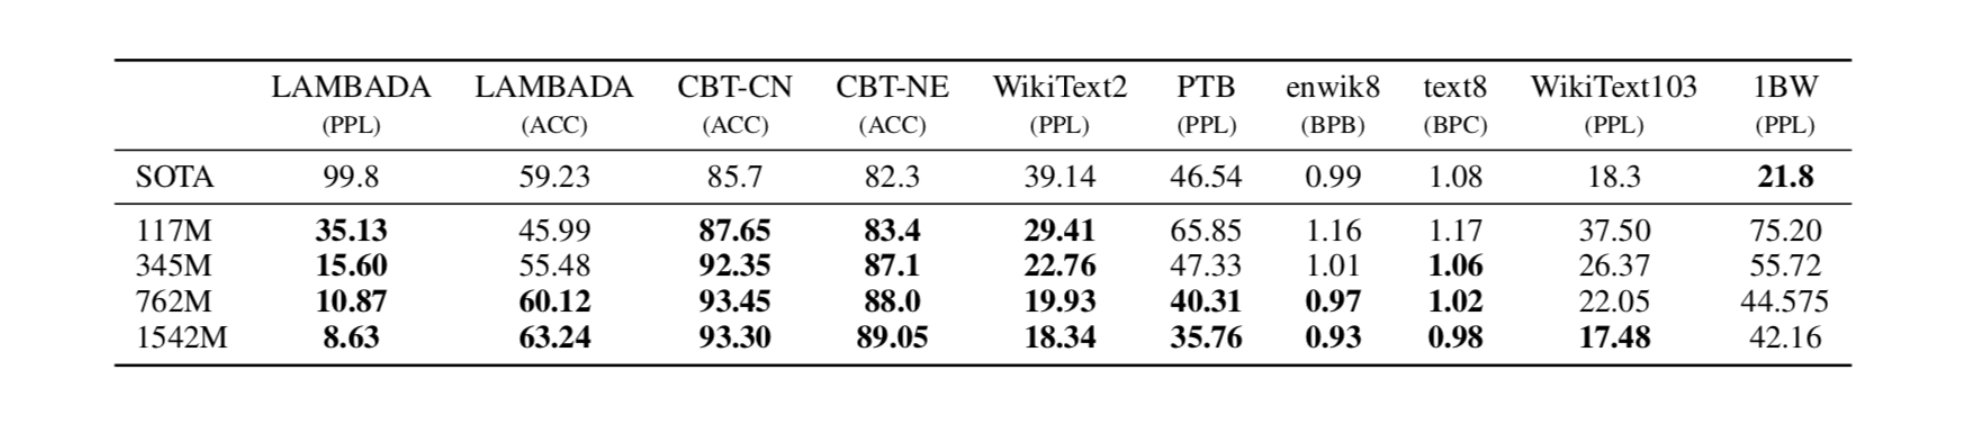

所以 GPT-2 对于其他预训练模型的一个突破就在于，它能够在未针对特定下游任务进行训练的条件下，就在下游任务如：阅读理解、机器翻译、问答和文本概括上有很好的表现。这也表明了，在模型足够大，训练数据足够充足时，无监督训练技术也能训练出在多种下游任务上有很好表现的模型。

因为监督学习需要大量的数据，并且需要被仔细清理过的数据，想要得到这样的数据需要昂贵的人力成本。无监督学习可以克服这个缺点，因为它不需要人工标注，有大量现成的数据可以利用。这也表明了 GPT-2 模型研究的意义。

在了解了构建 GPT-2 模型的思想后，接下来我们将详细了解一下 GPT-2 模型的结构。

### GPT-2 模型结构

GPT-2 的整体结构如下图，GPT-2 是以 Transformer 为基础构建的， 使用字节对编码的方法进行数据预处理，通过预测下一个词任务进行预训练的语言模型，下面我们从 GPT-2 的预处理方法出发，来一步步详细解析一下 GPT-2。

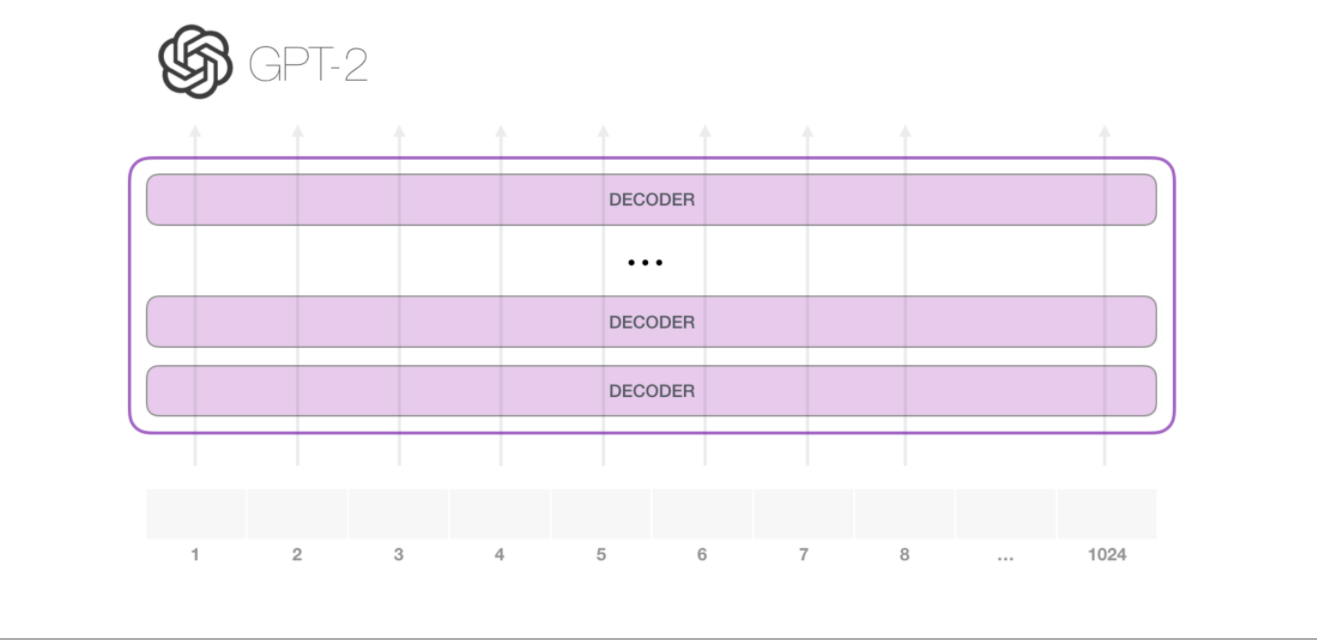

#### 字节对编码

GPT-2 模型在数据预处理时使用了字节对编码（Byte Pair Encoding，简称 BPE）方法，BPE 是一种能够解决未登录词问题，并减小词典大小的方法。它综合利用了单词层面编码和字符层面编码的优势，举例来说，我们要对下面的字符串编码，

<pre>
aaabdaaabac
</pre>

字节对 `aa` 出现的次数最多，所以我们将它替换成一个没在字符串中被用过的字符 `Z` ，

<pre>
ZabdZabac
Z=aa
</pre>

然后我们重复这个过程，用 `Y` 替换 `ab` ，

<pre>
ZYdZYac
Y=ab
Z=aa
</pre>

继续，用 `X` 替换 `ZY` ，

<pre>
XdXac
X=ZY
Y=ab
Z=aa
</pre>

这个过程重复进行，直到没有字节对出现超过一次。当需要解码时，就将上述替换过程反向进行。

下面是一段 BPE 算法原文中对 BPE 算法的实现：

In [ ]:
import re
import collections


def get_stats(vocab):
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i], symbols[i+1]] += freq  # 计算字节对出现频率
    return pairs


def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))  # 将字节对中可解释为正则运算符的字符转义
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')  # 将要合并的字节对前后只能为空白字符
    for word in v_in:
        w_out = p.sub(''.join(pair), word)  # 合并符合条件的字节对
        v_out[w_out] = v_in[word]
    return v_out

In [ ]:
vocab = {'l o w </w>': 5, 'l o w e r </w>': 2,
         'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
num_merges = 10
for i in range(num_merges):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get)  # 选择频率最大的字节对
    vocab = merge_vocab(best, vocab)
    print(best)

#### 单向 Transformer 解码器结构

GPT-2 模型由多层单向 Transformer 的解码器部分构成，本质上是自回归模型，自回归的意思是指，每次产生新单词后，将新单词加到原输入句后面，作为新的输入句。其中 Transformer 解码器结构如下图：

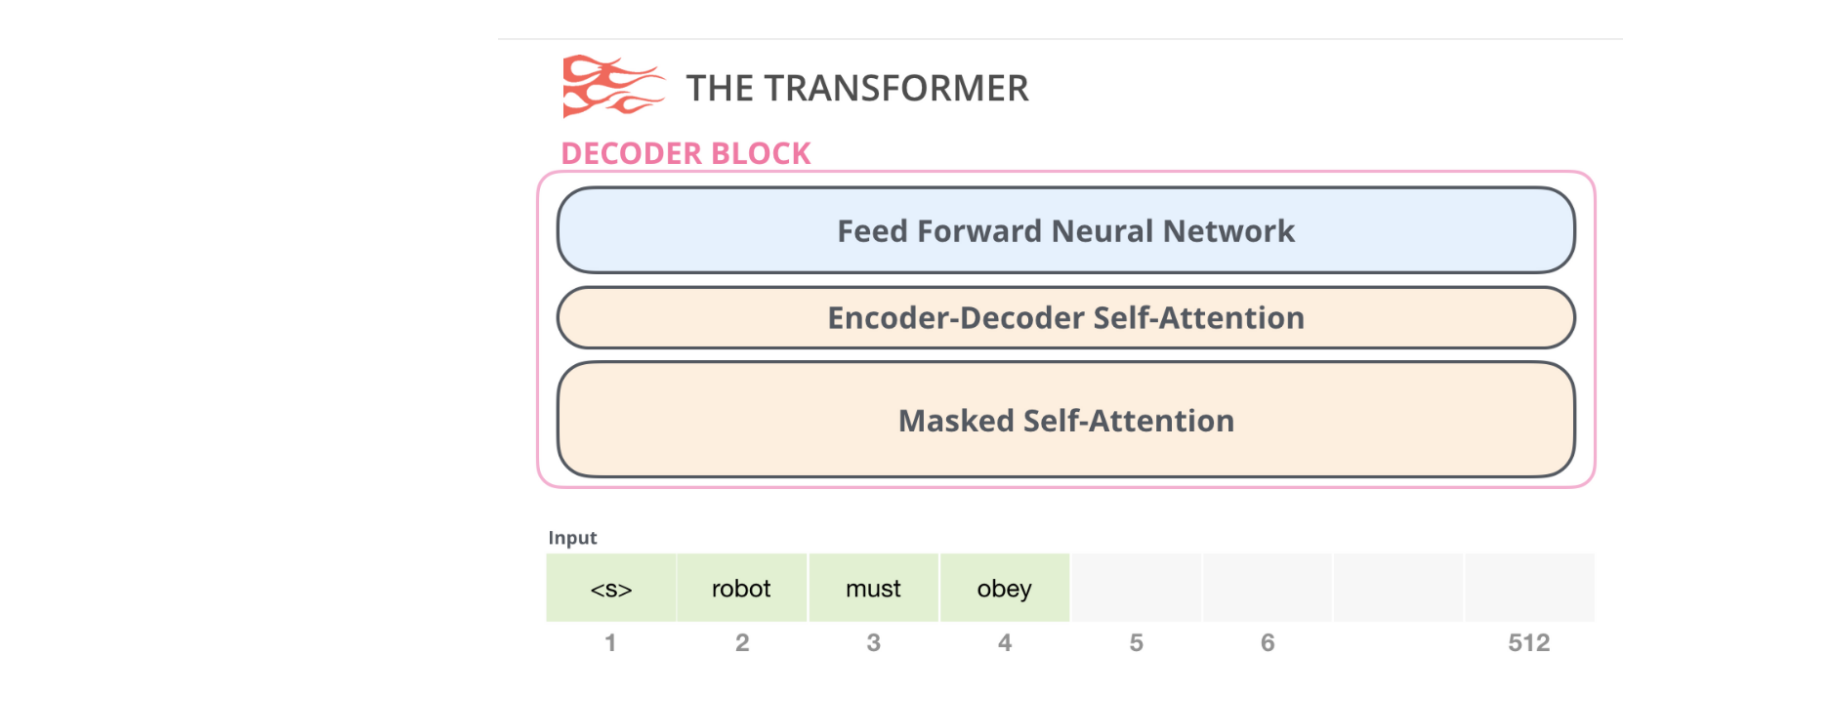

GPT-2 模型中只使用了多个 Masked Self-Attention 和 Feed Forward Neural Network 两个模块。如下图所示：

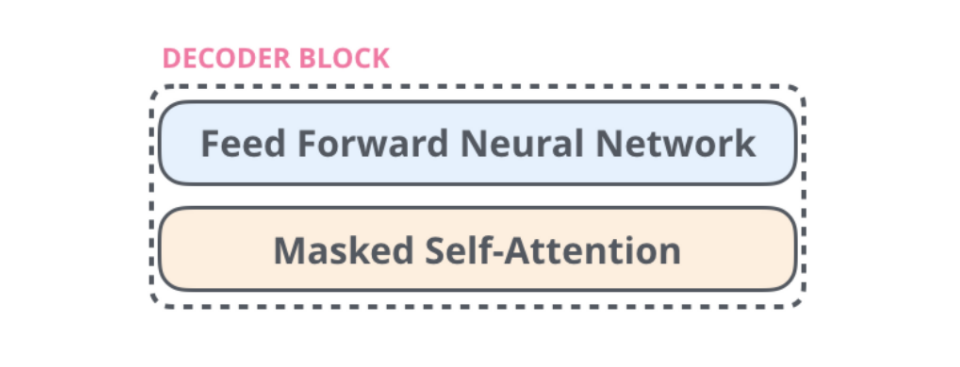

可以看到，GPT-2 模型会将语句输入上图所示的结构中，预测下一个词，然后再将新单词加入，作为新的输入，继续预测。损失函数会计算预测值与实际值之间的偏差。

从上一节我们了解到 BERT 是基于双向 Transformer 结构构建，而 GPT-2 是基于单向 Transformer，这里的双向与单向，是指在进行注意力计算时，BERT会同时考虑被遮蔽词左右的词对其的影响，而 GPT-2 只会考虑在待预测词位置左侧的词对待预测词的影响。

通过上述数据预处理方法和模型结构，以及大量的数据训练出了 GPT-2 模型。OpenAI 团队由于安全考虑，没有开源全部训练参数，而是提供了小型的预训练模型，接下来我们将在 GPT-2 预训练模型的基础上进行实验。

### GPT-2 文本生成

GPT-2 就是一个语言模型，能够根据上文预测下一个单词，所以它就可以利用预训练已经学到的知识来生成文本，如生成新闻。也可以使用另一些数据进行微调，生成有特定格式或者主题的文本，如诗歌、戏剧。所以接下来，我们会用 GPT-2 模型进行一个文本生成实验。

#### 预训练模型生成新闻

想要直接运行一个预训练好的 GPT-2 模型，最简单的方法是让它自由工作，即随机生成文本。换句话说，在开始时，我们给它一点提示，即一个预定好的起始单词，然后让它自行地随机生成后续的文本。

但这样有时可能会出现问题，例如模型陷入一个循环，不断生成同一个单词。为了避免这种情况， GPT-2 设置了一个 `top-k` 参数，这样模型就会从概率前 k 大的单词中随机选取一个单词，作为下一个单词。下面是选择 `top-k` 的函数的实现，

In [ ]:
import random

def select_top_k(predictions, k=10):
    predicted_index = random.choice(
        predictions[0, -1, :].sort(descending=True)[1][:10]).item()
    return predicted_index

下面引入 GPT-2 模型，我们将使用在 PyTorch-Transformers 模型库中封装好的 `GPT2Tokenizer()` 和 `GPT2LMHeadModel()` 类来实际看一下 GPT-2 在预训练后的对下一个词预测的能力。首先，需要安装 PyTorch-Transformers。

In [ ]:
!pip install pytorch_transformers==1.0  # 安装 PyTorch-Transformers

使用 PyTorch-Transformers 模型库，先设置好准备输入模型的例子，使用 `GPT2Tokenizer()` 建立分词器对象对原句编码。

In [ ]:
import torch
from pytorch_transformers import GPT2Tokenizer

import logging
logging.basicConfig(level=logging.INFO)

# 载入预训练模型的分词器
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# 使用 GPT2Tokenizer 对输入进行编码
text = "Yesterday, a man named Jack said he saw an alien,"
indexed_tokens = tokenizer.encode(text)
tokens_tensor = torch.tensor([indexed_tokens])
tokens_tensor.shape

接下来使用 `GPT2LMHeadModel()` 建立模型，并将模型模式设为验证模式。由于预训练模型参数体积很大，且托管在外网，所以本次实验先从蓝桥云课镜像服务器下载预训练模型，本地实验无需此步骤。

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/1372/gpt2-shiyanlou.zip"
!unzip -o "gpt2-shiyanlou.zip"

In [ ]:
from pytorch_transformers import GPT2LMHeadModel

# 读取 GPT-2 预训练模型
model = GPT2LMHeadModel.from_pretrained("./")
model.eval()

In [ ]:
total_predicted_text = text
n = 100  # 预测过程的循环次数
for _ in range(n):
    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    predicted_index = select_top_k(predictions, k=10)
    predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
    total_predicted_text += tokenizer.decode(predicted_index)

    if '<|endoftext|>' in total_predicted_text:
        # 如果出现文本结束标志，就结束文本生成
        break

    indexed_tokens += [predicted_index]
    tokens_tensor = torch.tensor([indexed_tokens])

print(total_predicted_text)

运行结束后，我们观察一下模型生成的文本，可以看到，大致感觉上这好像是一段正常的文本，不过，仔细看就会发现语句中的逻辑问题，这也是之后研究人员会继续攻克的问题。

除了直接利用预训练模型生成文本，我们还可以使用微调的方法使 GPT-2 模型生成有特定风格和格式的文本。

#### 微调生成戏剧文本

接下来，我们将使用一些戏剧剧本对 GPT-2 进行微调。由于 OpenAI 团队开源的 GPT-2 模型预训练参数为使用英文数据集预训练后得到的，虽然可以在微调时使用中文数据集，但需要大量数据和时间才会有好的效果，所以这里我们使用了英文数据集进行微调，从而更好地展现 GPT-2 模型的能力。

首先，下载训练数据集，这里使用了莎士比亚的戏剧作品[《罗密欧与朱丽叶》](http://shakespeare.mit.edu/romeo_juliet/full.html)作为训练样本。数据集我们已经提前下载好并放在蓝桥云课服务器中，可以通过以下命令下载。

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/1372/romeo_and_juliet.zip"
!unzip -o "romeo_and_juliet.zip"

下载好数据后，读取数据文件。

In [ ]:
with open('./romeo_and_juliet.txt', 'r') as f:
    dataset = f.read()

len(dataset)

预处理训练集，将训练集编码、分段。

In [ ]:
indexed_text = tokenizer.encode(dataset)
del(dataset)

dataset_cut = []
for i in range(len(indexed_text)//512):
    # 将字符串分段成长度为 512
    dataset_cut.append(indexed_text[i*512:i*512+512])
del(indexed_text)

dataset_tensor = torch.tensor(dataset_cut)
dataset_tensor.shape

这里使用 PyTorch 提供的 `DataLoader()` 构建训练集数据集表示，使用 `TensorDataset()` 构建训练集数据迭代器。

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# 构建数据集和数据迭代器，设定 batch_size 大小为 2
train_set = TensorDataset(dataset_tensor,
                          dataset_tensor)  # 标签与样本数据相同
train_loader = DataLoader(dataset=train_set,
                          batch_size=2,
                          shuffle=False)
train_loader

检查是否机器有 GPU，如果有就在 GPU 运行，否则就在 CPU 运行。

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

开始训练。

In [ ]:
from torch import nn
from torch.autograd import Variable
import time

pre = time.time()

epoch = 30  # 循环学习 30 次

model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # 定义优化器

for i in range(epoch):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(
            target).to(device)

        optimizer.zero_grad()

        loss, logits, _ = model(data, labels=target)

        total_loss += loss

        loss.backward()
        optimizer.step()

        if batch_idx == len(train_loader)-1:
            # 在每个 Epoch 的最后输出一下结果
            print('average loss:', total_loss/len(train_loader))

print('训练时间：', time.time()-pre)

训练结束后，可以使模型生成文本，观察输出。

In [ ]:
text = "From fairest creatures we desire"  # 这里也可以输入不同的英文文本
indexed_tokens = tokenizer.encode(text)
tokens_tensor = torch.tensor([indexed_tokens])

In [ ]:
model.eval()
total_predicted_text = text

# 使训练后的模型进行 500 次预测
for _ in range(500):
    tokens_tensor = tokens_tensor.to('cuda')

    with torch.no_grad():
        outputs = model(tokens_tensor)
        predictions = outputs[0]

    predicted_index = select_top_k(predictions, k=10)

    predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
    total_predicted_text += tokenizer.decode(predicted_index)
    if '<|endoftext|>' in total_predicted_text:
        # 如果出现文本结束标志，就结束文本生成
        break

    indexed_tokens += [predicted_index]

    if len(indexed_tokens) > 1023:
        # 模型最长输入长度为1024，如果长度过长则截断
        indexed_tokens = indexed_tokens[-1023:]

    tokens_tensor = torch.tensor([indexed_tokens])

print(total_predicted_text)

从生成结果可以看到，模型已经学习到了戏剧剧本的文本结构。但是仔细读起来会发现缺少逻辑和关联，这是因为由于时间和设备的限制，对模型的训练比较有限。如果有条件可以用更多的数据，训练更长的时间，这样模型也会有更好的表现。

### 实验总结

本次实验中，我们首先学习了 GPT-2 的构建思想和它的结构，并观察了预训练结果，最后使用了 Fine-Tuning 方法应用 GPT-2 预训练模型进行了戏剧文本生成任务。

<i class="fa fa-link" aria-hidden="true"> 相关链接</i> 

- [Improving Language Understanding by Generative Pre-Training](https://openai.com/blog/language-unsupervised/)
- [Language Models are Unsupervised Multitask Learners](https://openai.com/blog/better-language-models/)
- [OpenAI 开源的 GPT-2 模型](https://github.com/openai/gpt-2)
- [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162)
- [GPT-2 可视化](https://jalammar.github.io/illustrated-gpt2/)